In [261]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import collections
import os 
from __future__ import print_function
from collections import Counter 

from keras import backend as K
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, core, normalization
from keras.layers import Conv2D, MaxPooling2D , LSTM, GRU
from keras import regularizers
from keras.backend import stack
from keras.utils import plot_model

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import reshape_layer as RL

import math

In [2]:
dictionary = {}
dictionary["/Kick"] = 1
dictionary["/Snares"] = 2
dictionary["/Toms"] = 4
dictionary["/Cymbals/Hi Hats"] = 8
num_labels = len(dictionary)
total_outcomes = np.power(2, len(dictionary)) #all permutations 

In [125]:

dataDir = 'data' # change to '/input' when using floydhub
print(os.listdir(dataDir))
dataSource = dataDir + '/time_series_normalized.npy.npz'
#dataSource = 'data/fft_time_series.npy'

f = np.load(dataSource)
ind = f.files
features = f[ind[0]]
print(features.shape)
print(features[0,0].shape)
print(features[0,1].shape)
print(features[0,2].shape)
print(features[0,3].shape)

['.DS_Store', '.floyddata', 'time_series_normalized.npy.npz']
(1, 4)
(2,)
(2, 409, 8)
(2, 513, 409)
(2, 39, 409)


In [126]:
def normalizeMFCC (mfcc):
    for i in range(mfcc.shape[1]):
        mean = np.mean(mfcc[:,i])
        std =  np.std (mfcc[:,i])
        mfcc[:,i] = np.subtract(mfcc[:,i], mean)/std
    return mfcc

def get_gradients(model):
    """Return the gradient of every trainable weight in model

    Parameters
    -----------
    model : a keras model instance

    First, find all tensors which are trainable in the model. Surprisingly,
    `model.trainable_weights` will return tensors for which
    trainable=False has been set on their layer (last time I checked), hence the extra check.
    Next, get the gradients of the loss with respect to the weights.

    """
    weights = [tensor for tensor in model.trainable_weights if model.get_layer(tensor.name[:-2]).trainable]
    optimizer = model.optimizer

    return optimizer.get_gradients(model.total_loss, weights)

In [390]:
len_features = len(features)
test_percent = 0.2
testSize = int(len_features*test_percent)
trainSize = len_features - testSize


freq_axis = features[0,3].shape[1]
samples = features[0,3].shape[2]

Y = features[0,1][:,:,4:]
X = features[0,3]

print(X.shape)
print(Y.shape)

indicies = np.arange(len(Y))
train_X, test_X, train_Y, test_Y, indices_train, indices_test = train_test_split(X, Y, indicies, test_size=test_percent)

train_X = normalizeMFCC (train_X)
test_X = normalizeMFCC (test_X) #might not be needed

#test_Y[np.where(test_Y == 0)] = -1.
#train_Y[np.where(train_Y == 0)] = -1.

train_X = np.expand_dims(train_X, axis=3)
test_X = np.expand_dims(test_X, axis=3)

print("Train Set Shape:")
print(train_X.shape)

print("Test Set Shape:")
print(test_X.shape)

print(np.sum(np.isnan(train_X)))
print(np.sum(np.isnan(test_X)))

"""
print("Train Categories")
c1 = Counter([i for i in Y[indices_train]])
print (c1.items()) 
print("Test Categories")
c1 = Counter([i for i in Y[indices_test]])
print (c1.items()) 

print("Total Categories")
c1 = Counter([i for i in Y[:]])
print (c1.items())
"""

(2, 39, 409)
(2, 409, 4)
Train Set Shape:
(1, 39, 409, 1)
Test Set Shape:
(1, 39, 409, 1)
0
0


'\nprint("Train Categories")\nc1 = Counter([i for i in Y[indices_train]])\nprint (c1.items()) \nprint("Test Categories")\nc1 = Counter([i for i in Y[indices_test]])\nprint (c1.items()) \n\nprint("Total Categories")\nc1 = Counter([i for i in Y[:]])\nprint (c1.items())\n'

In [395]:
### MODEL PARAMETERS ###
batch_size = 1
epochs = 6
num_conv_layers = 4
num_recurrent_layers = 1
IS_LSTM = False
kernel_size = (5,5)
pool_kernel = (2,1) ## DOUBLE CHECK THIS ##
hidden_units = 256
conv_activation = 'relu'
recurr_activation = 'relu'
loss_metric =  'categorical_crossentropy'#'mean_squared_error' #
learning_rate = 0.01
input_shape = (freq_axis, samples, 1) #assuming channels last  DOUBLE CHECK IF THIS IS CORRECT ####
dropout_rate = 0.3
l_theta = .01
print("Input Shape: ", input_shape)

Input Shape:  (39, 409, 1)


In [396]:
### MODEL ###
print('Building model...')
model = Sequential()

print("Input Shape: ", input_shape)

### CONV NETS ###
# first conv layer (to specify shape)
conv_input = Conv2D(hidden_units, kernel_size, strides=(1,1), padding="SAME", activation=conv_activation, input_shape = input_shape, kernel_regularizer=regularizers.l2(l_theta))
model.add(conv_input)
pool = MaxPooling2D(pool_size=pool_kernel)
model.add(pool)
model.add(core.Dropout(dropout_rate))
print(conv_input, conv_input.output_shape)
print(pool, pool.output_shape)

for i in range(num_conv_layers-2):
    conv = Conv2D(hidden_units, kernel_size, strides=(1,1), padding="SAME", activation=conv_activation, kernel_regularizer=regularizers.l2(l_theta))
    model.add(conv)
    pool = MaxPooling2D(pool_size=pool_kernel)
    model.add(pool) ## might have to use 3d pooling
    model.add(core.Dropout(dropout_rate))
    #model.add(normalization.BatchNormalization())
    print(conv, conv.output_shape)
    print(pool, pool.output_shape)
conv = Conv2D(hidden_units, kernel_size, strides=(1,1), padding="SAME", activation=conv_activation, kernel_regularizer=regularizers.l2(l_theta))
model.add(conv)
conv_output = MaxPooling2D(pool_size=pool_kernel)
model.add(conv_output)
model.add(core.Dropout(dropout_rate))
#model.add(normalization.BatchNormalization())
print(conv,conv.output_shape)
print(conv_output,conv_output.output_shape)

### STACKING ###
shape = conv_output.output.shape
F_prime = shape[1].value
T = shape[2].value
M = shape[3].value

r = RL.custom_reshape((-1,T, F_prime*M))
model.add(r)
print(r,r.output_shape)

reshaped = core.Reshape((T, F_prime*M), input_shape=r.output_shape[1:])
model.add(reshaped)
print(reshaped,reshaped.output_shape)

#reshaped = core.Reshape((T, F_prime*M), input_shape=shape[1:])
#model.add(reshaped)
#print(reshaped,reshaped.output_shape)

### RECURRENT LAYERS ###
for i in range(num_recurrent_layers):
    if IS_LSTM:
        recurr = LSTM(hidden_units, return_sequences=True, activation=recurr_activation, dropout=0.3, recurrent_dropout=0.0, input_shape = (-1,T, F_prime*M))
    else:
        recurr = GRU(hidden_units, return_sequences=True, activation=recurr_activation, dropout=0.3, recurrent_dropout=0.0)
    model.add(recurr)
    print(recurr,recurr.output_shape)

    
### FEEDFORWARD NET ###
D = Dense(num_labels, activation='sigmoid')
model.add( D )
print(D, D.output_shape)

### LOSS AND OPTIMIZER ###
optimizer_func = keras.optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
keras.initializers.RandomNormal(mean=0.0, stddev=1, seed=None)
model.compile(loss=loss_metric, optimizer=optimizer_func, metrics=['accuracy'])

#plot_model(model, to_file='model.png')

print("Number of parameters:", model.count_params())


Building model...
Input Shape:  (39, 409, 1)
<keras.layers.convolutional.Conv2D object at 0x3838fb710> (None, 39, 409, 256)
<keras.layers.pooling.MaxPooling2D object at 0x3756dc3d0> (None, 19, 409, 256)
<keras.layers.convolutional.Conv2D object at 0x3756dcbd0> (None, 19, 409, 256)
<keras.layers.pooling.MaxPooling2D object at 0x3756dc490> (None, 9, 409, 256)
<keras.layers.convolutional.Conv2D object at 0x37573a9d0> (None, 9, 409, 256)
<keras.layers.pooling.MaxPooling2D object at 0x37572b5d0> (None, 4, 409, 256)
<keras.layers.convolutional.Conv2D object at 0x379a53b90> (None, 4, 409, 256)
<keras.layers.pooling.MaxPooling2D object at 0x375885b50> (None, 2, 409, 256)
<reshape_layer.custom_reshape object at 0x3756ffc10> (None, 1, 409, 512)
<keras.layers.core.Reshape object at 0x379a8f3d0> (None, 409, 512)
<keras.layers.recurrent.GRU object at 0x379ce5710> (None, 409, 256)
<keras.layers.core.Dense object at 0x379ce5510> (None, 409, 4)
Number of parameters: 5514244


In [397]:
### Train Model ###

print('Training...')
print(train_X.shape, train_Y.shape)
model.fit(train_X, train_Y, batch_size=batch_size, epochs=epochs, validation_split=.2, validation_data=(test_X, test_Y))

"""
score, acc1, acc2 = model.evaluate(test_X, test_Y, batch_size=batch_size)
print('Test score:', score)
print('Test accuracy 1:', acc1)
"""

Training...
(1, 39, 409, 1) (1, 409, 4)
Train on 1 samples, validate on 1 samples
Epoch 1/50
1/1 [==============================] - 15s - loss: 8.6946 - acc: 0.0978 - val_loss: 10.2887 - val_acc: 0.2127
Epoch 2/50
1/1 [==============================] - 2s - loss: 6.8925 - acc: 0.2249 - val_loss: 9.0486 - val_acc: 0.2127
Epoch 3/50
1/1 [==============================] - 2s - loss: 5.8044 - acc: 0.2249 - val_loss: 11.8679 - val_acc: 0.2127
Epoch 4/50
1/1 [==============================] - 2s - loss: 8.8198 - acc: 0.2249 - val_loss: 10.9434 - val_acc: 0.2127
Epoch 5/50
1/1 [==============================] - 2s - loss: 7.7603 - acc: 0.2249 - val_loss: 7.2289 - val_acc: 0.2127
Epoch 6/50
1/1 [==============================] - 2s - loss: 6.2025 - acc: 0.2249 - val_loss: 6.9573 - val_acc: 0.1834
Epoch 7/50
1/1 [==============================] - 2s - loss: 6.4668 - acc: 0.1540 - val_loss: 7.5050 - val_acc: 0.1222
Epoch 8/50
1/1 [==============================] - 2s - loss: 7.1821 - acc: 0.0929

"\nscore, acc1, acc2 = model.evaluate(test_X, test_Y, batch_size=batch_size)\nprint('Test score:', score)\nprint('Test accuracy 1:', acc1)\n"

In [398]:
testPredict = model.predict(train_X)

In [399]:
input_num = 9
output_num = 12

first_layer = K.function([model.layers[0].input, K.learning_phase()],
                                  [model.layers[0].output])

get_5rd_layer_output = K.function([model.layers[0].input, K.learning_phase()],
                                  [model.layers[input_num].output])
get_reshape_layer_output = K.function([model.layers[0].input, K.learning_phase()],
                                  [model.layers[output_num].output])

#gradients = get_gradients(model)

# output in test mode = 0
first = first_layer([test_X, 0])[0]
layer_output = get_5rd_layer_output([test_X, 0])[0]
layer_output_reshape = get_reshape_layer_output([test_X, 0])[0]
print(first.shape)
print(layer_output.shape)
print(layer_output_reshape.shape)

first_batch = first[0]
batch = layer_output[0]
batch_reshape = layer_output_reshape[0]
print(first_batch.shape)
print(batch.shape)
print(batch_reshape.shape)

#print(np.sum(np.isnan(model.layers[0].input)))
print(np.sum(np.isnan(first_batch[:,:,:])))
print(np.sum(np.isnan(batch)))
print(np.sum(np.isnan(batch_reshape)))

#print(gradients.shape)

(1, 39, 409, 256)
(1, 4, 409, 256)
(1, 409, 512)
(39, 409, 256)
(4, 409, 256)
(409, 512)
0
0
0


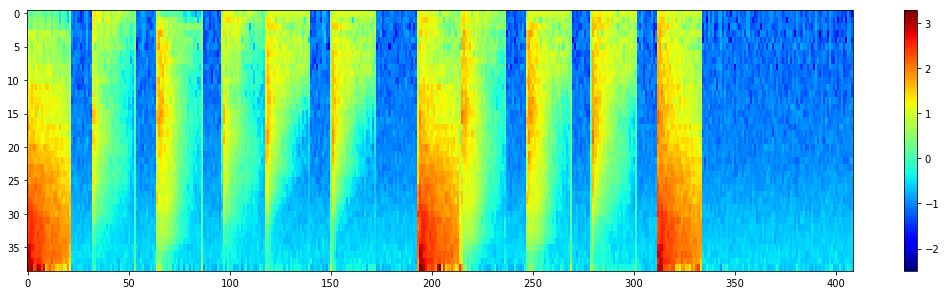

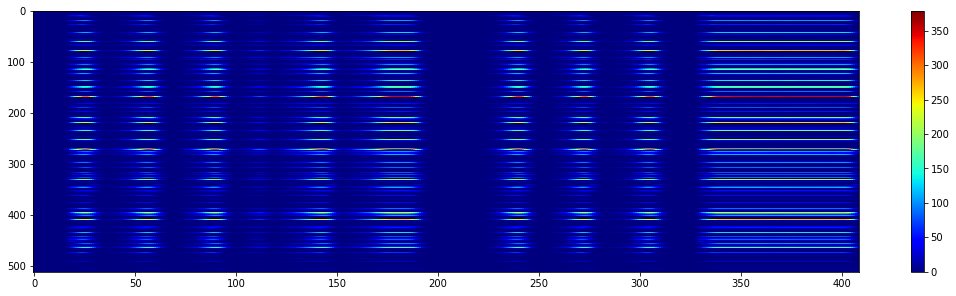

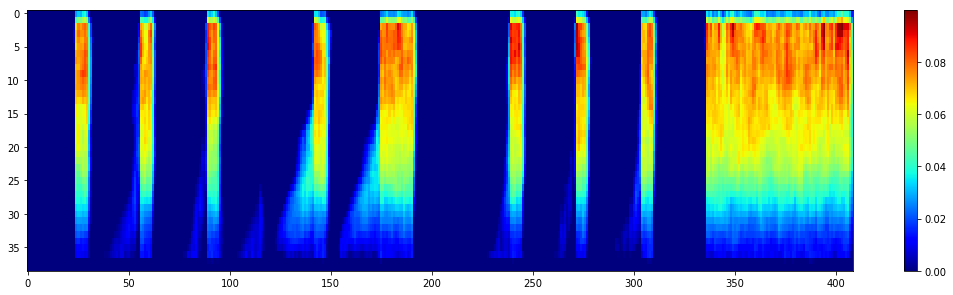

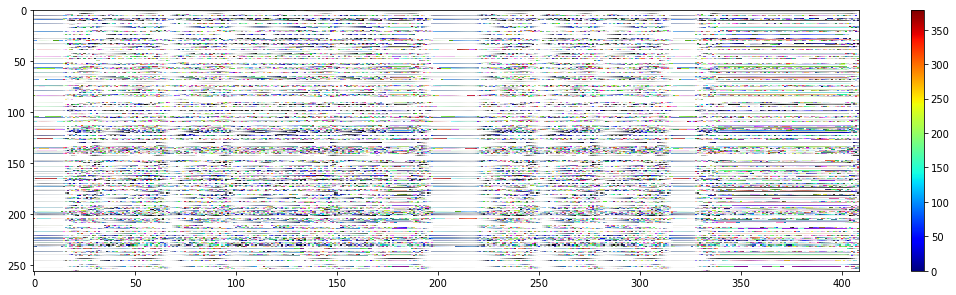

In [403]:
fig = plt.gcf()
fig.set_size_inches(18.5, 4.8)
plt.imshow(test_X[0,0:,:,0], cmap=colormap, interpolation='nearest', aspect='auto')
plt.colorbar()
plt.show()

fig = plt.gcf()
fig.set_size_inches(18.5, 4.8)
plt.imshow(np.transpose(batch_reshape), cmap=colormap, interpolation='nearest', aspect='auto')
plt.colorbar()
#plt.clim(-1,1)
plt.show()

fig = plt.gcf()
fig.set_size_inches(18.5, 4.8)
plt.imshow(first_batch[:,:,0], cmap=colormap, interpolation='nearest', aspect='auto')
plt.colorbar()
#plt.clim(-1,1)
plt.show()

fig = plt.gcf()
fig.set_size_inches(18.5, 4.8)
plt.imshow(np.transpose(batch)[:,:], cmap=colormap, interpolation='nearest', aspect='auto')
plt.colorbar()
#plt.clim(-1,1)
plt.show()



In [404]:
threshold = 0.5
binarized = np.where(testPredict>threshold, 1, 0)
print(np.sum(np.isnan(testPredict)))

errors = np.equal(binarized, test_Y)
#print(errors)
print(np.sum(errors))
print(errors.shape[0]*errors.shape[1]*errors.shape[2])
errorIndicies = np.where(errors == False)
#print(binarized.shape)]

0
392
1636


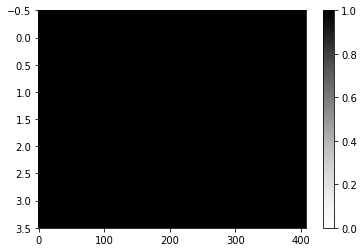

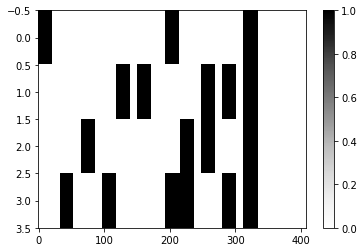

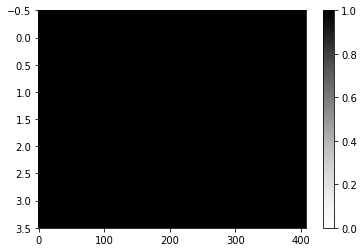

In [405]:
index = 0
prediction = binarized[index,:, :]
ground = test_Y[index,:, :].astype(int)

plt.imshow(np.transpose(testPredict[index,:,:]), cmap='Greys', aspect='auto')
plt.colorbar()
plt.clim(0,1)
plt.show()
plt.imshow(np.transpose(ground[:,:]), cmap='Greys', interpolation='nearest', aspect='auto')
plt.colorbar()
plt.show()
plt.imshow(np.transpose(prediction[:,:]), cmap='Greys', interpolation='nearest', aspect='auto')
plt.colorbar()
plt.clim(0,1)
plt.show()
